# Tumor Classification

Use only gene expression data from protein-coding genes to build different classifiers.

- [Tissue](#Tissue)
- [Tumor](#Tumor)

In [102]:
# Data
import pandas as pd
import numpy as np
import rnaseq_lib as r
from multiprocessing import Pool

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Classifiers
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
# Feature Selection
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
# Model Selection
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import StratifiedKFold
# Processing
from sklearn.preprocessing import MinMaxScaler

Define multicore and standard classifiers

In [101]:
multicore_classifiers = {
            'RandomForest': RandomForestClassifier(n_jobs=-1),
            'ExtraTrees': ExtraTreesClassifier(n_jobs=-1),
            'GaussianProcessClassifier': GaussianProcessClassifier(n_jobs=-1),
            'KNeighborsClassifier': KNeighborsClassifier(n_jobs=-1)}

classifiers = {'GradientBoostingClassifier': GradientBoostingClassifier(),
                            'AdaBoost': AdaBoostClassifier(),
                            'LinearSVC': LinearSVC(),
                            'DecisionTreeClassifier': DecisionTreeClassifier(),
                            'GaussianNB': GaussianNB()}

In [5]:
# Inputs
## Synapse ID: syn11515015
df_path = '/mnt/rnaseq-cancer/Objects/tcga-gtex-metadata-expression.tsv'
df = pd.read_csv(df_path, sep='\t', index_col=0, dtype=r.tissues.dtype)

In [48]:
def get_training_data(df, y='tissue'):
    return np.array(df[df.columns[17:]]), np.array(df[y])

In [92]:
def run_rfecv(clf, X, y, step=1000, kfolds=2):
    rfecv = RFECV(estimator=clf, step=step, cv=StratifiedKFold(kfolds),
                  scoring='accuracy')
    rfecv.fit(X, y)
    return rfecv

# Classifying Tissue

Get training samples and scale between 0 and 1

In [ ]:
scaler = MinMaxScaler()

X, y = get_training_data(df)
X = scaler.fit_transform(X)

Use a random classifier to estimate good starting number for feature selection

In [ ]:
%%time
clf = RandomForestClassifier(n_jobs=-1)
rfecv = run_rfecv(clf, X, y, step=1000, kfolds=3)

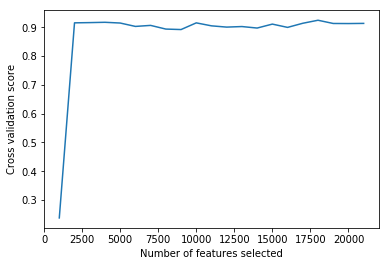

In [74]:
plt.plot([x*1000 for x in xrange(1, len(rfecv.grid_scores_) + 1)], rfecv.grid_scores_)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.show()

Cross validation score appears to level off around ~2500 features. 

In [93]:
X_new = SelectKBest(chi2, k=2500).fit_transform(X, y)

### Train Classifiers

In [ ]:
scores = {}
for k, v in multicore_classifiers.iteritems():
    scores[k] = cross_val_score(v, X_new, y)

# Classifying Tumor

In [106]:
scores

{'ExtraTrees': array([0.83210282, 0.94575342, 0.91780822]),
 'GaussianProcessClassifier': array([0.02570413, 0.02575342, 0.02575342]),
 'KNeighborsClassifier': array([0.71178562, 0.87205479, 0.80136986]),
 'RandomForest': array([0.89691004, 0.95917808, 0.94356164])}

# Classifying Type

# Classifying Type by Tissue